In [12]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("XX", 1), ("YY", 1), ("ZI", 1)])

In [13]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

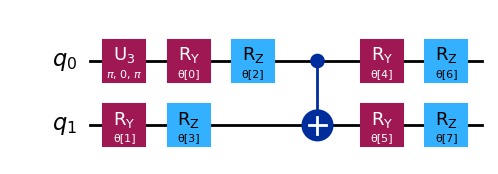

In [14]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')

In [21]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

simulator = AerSimulator()

result = simulator.run(raw_ansatz, shots=8192).result()

statistics = result.get_counts()

display(plot_histogram(statistics))

AerError: 'unknown instruction: TwoLocal'

In [15]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

In [16]:
import numpy as np

x0 = np.ones(raw_ansatz.num_parameters)
print(x0)


[1. 1. 1. 1. 1. 1. 1. 1.]


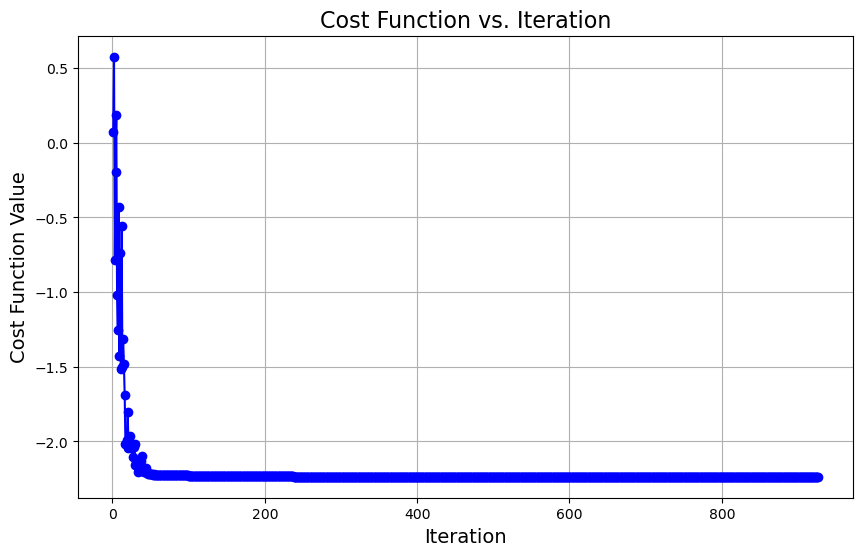

In [18]:
# SciPy minimizer routine
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# List to store cost function values at each iteration
cost_values = []

# Wrapper function to track the cost function value
def cost_func_with_tracking(params, *args):
    cost = cost_func_vqe(params, *args)  # Calculate the cost
    cost_values.append(cost)            # Append the cost value to the list
    return cost

# Start the optimization
start_time = time.time()

result = minimize(
    cost_func_with_tracking,  # Use the wrapper function
    x0,
    args=(raw_ansatz, observable_1, estimator),
    method="COBYLA",
    options={'maxiter': 1000, 'disp': True}
)

end_time = time.time()
execution_time = end_time - start_time

# Plotting the cost function values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cost_values) + 1), cost_values, marker='o', color='b')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Cost Function Value', fontsize=14)
plt.title('Cost Function vs. Iteration', fontsize=16)
plt.grid()
plt.show()


In [19]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.2360676528622934
       x: [ 1.571e+00  2.066e+00  2.021e-03  1.038e+00  1.570e+00
            1.569e+00  1.300e+00  2.311e+00]
    nfev: 926
   maxcv: 0.0

In [20]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 926
Time (s): 2.0475988388061523
Percent error: 1.45e-07
